In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

In [2]:
ctd = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')
ctd$Time = conv_excel_time(ctd$DateTime, tz = 'UTC')

str(ctd)

'data.frame':	41780 obs. of  35 variables:
 $ Cruise          : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle           : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo         : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime        : num  42888 42888 42888 42888 42888 ...
 $ Direction       : chr  "down" "down" "down" "down" ...
 $ Pressure        : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth           : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C           : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C           : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1           : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2           : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00           : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11           : num  33.4 33.4 33.4 33.4 33.4 ...
 $ O2              : num  195 196 195 195 195 ...
 $ O2.Sat          : num  81 81.1 81 80.9 80.8 ...
 $ PAR.surface     : num  8632 8632 8632 8632 8632 ...
 $ PAR  

In [3]:
ctd.log = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet='Data')
ctd.log$time = conv_excel_time(ctd.log$DateTime, tz = 'GMT')

str(ctd.log)

'data.frame':	90 obs. of  11 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Transect1" ...
 $ EventNo     : num  3 14 127 130 136 141 146 154 161 168 ...
 $ Cast        : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Station.Type: chr  "test" "test" "experimental" "transect" ...
 $ DateTime    : num  42888 42889 42893 42894 42894 ...
 $ Lat         : num  33.1 34.3 33.9 34.9 34.9 ...
 $ Lon         : num  -118 -120 -122 -121 -121 ...
 $ Notes       : chr  "SPAR off" "Santa Barbara Basin (Nuts are off at depth). no PAR sensor SPAR off" "no PAR sensor" NA ...
 $ Actions     : chr  "deleted SPAR values" "deleted SPAR values" NA NA ...
 $ time        : POSIXct, format: "2017-06-01 17:16:19" "2017-06-02 12:10:50" ...


In [4]:
add.position = function(ctd, ctd.log) {
    ctd$Lat = NA
    ctd$Lon = NA
    ctd$Type = NA
    
    rej = c()
    for (i in 1:nrow(ctd)) {
        l = which(ctd.log$EventNo == ctd$EventNo[i])

        if (length(l) == 1) {
            ctd$Lat[i] = ctd.log$Lat[l]
            ctd$Lon[i] = ctd.log$Lon[l]
            ctd$Type = ctd.log$Station.Type[l]
        } else {
            rej = c(rej, i)
        }
    }
    print(paste0('Number of unmatched bins: ', length(rej)))
    ctd
}

In [5]:
ctd = add.position(ctd, ctd.log)

[1] "Number of unmatched bins: 3440"


In [15]:
save(ctd, file = 'RStates/CTD.all.rdata')

In [16]:
ctd = ctd[!is.na(ctd$Lat),]
save(ctd, file = 'RStates/CTD.pos.rdata')

In [17]:
nrow(ctd)

[1] 38340

In [24]:
ctd = 

[1] "down"

---
# Par and Transmission analysis

In [84]:
pt.comparison.plot = function(cast){
    l = which(ctd$Cast == cast)
    
    if (max(ctd$PAR[l], na.rm = TRUE) < 100) {
        return()
    }
    PAR = ctd$PAR[l] / ctd$PAR[l[1]]
    TRANS = cumprod(ctd$Trans[l]/100)
    Depth = ctd$Pressure[l]
    
    plot(PAR, Depth, ylim=c(200, 0), yaxs='i', main=paste('Cast -', cast), pch=16, cex=0.6)
    points(TRANS, Depth, col='blue', pch=16, cex=0.3)
    
    plot(PAR, TRANS^2)
    lm.log = lm(TRANS^2 ~ PAR)
    lines(PAR, predict(lm.log)[1:length(PAR)])
}

unique(ctd$Cast)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
[76] 77 78 79 80 81 82 83 84

In [122]:
pdf('Output/CTD - Transmission and PAR analysis.pdf')
par(mfrow=c(2,2))

for (i in unique(ctd$Cast)) {
    pt.comparison.plot(i)
}

dev.off()

Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$PAR[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning me

png 
  2

In [120]:
tchl.comparison.plot = function(cast){
    l = which(ctd$Cast == cast & ctd$Pressure < 100)
    
    if (max(ctd$Fluor[l], na.rm = TRUE) < 1) {
        return()
    }
    
    CHL = ctd$Fluor[l] / max(ctd$Fluor[l], na.rm = TRUE)
    TRANS = ctd$Trans[l]/100
    Depth = ctd$Pressure[l]
    
    plot(CHL, Depth, ylim=c(200, 0), yaxs='i', main=paste('Cast -', cast), pch=16, cex=0.6, xlim=c(0,2))
    points(TRANS, Depth, col='blue', pch=16, cex=0.3)
    
    plot(CHL, TRANS, col=make.div.pal(ctd$Pressure[l], n = 100), pch=16, ylim=c(0.8,1), xlim=c(0,1))
    lm.log = lm(TRANS ~ CHL)
    points(CHL, predict(lm.log)[1:length(CHL)], pch=16, cex=0.5, col='red')
}

unique(ctd$Cast)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
[76] 77 78 79 80 81 82 83 84

In [123]:
pdf('Output/CTD - Transmission and CHL analysis.pdf')

par(mfrow=c(2,2))

for (i in unique(ctd$Cast)) {
    try(tchl.comparison.plot(i))
}

dev.off()

Warning message in max(ctd$Fluor[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ctd$Fluor[l], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

png 
  2

## Plot Transmission Profiles

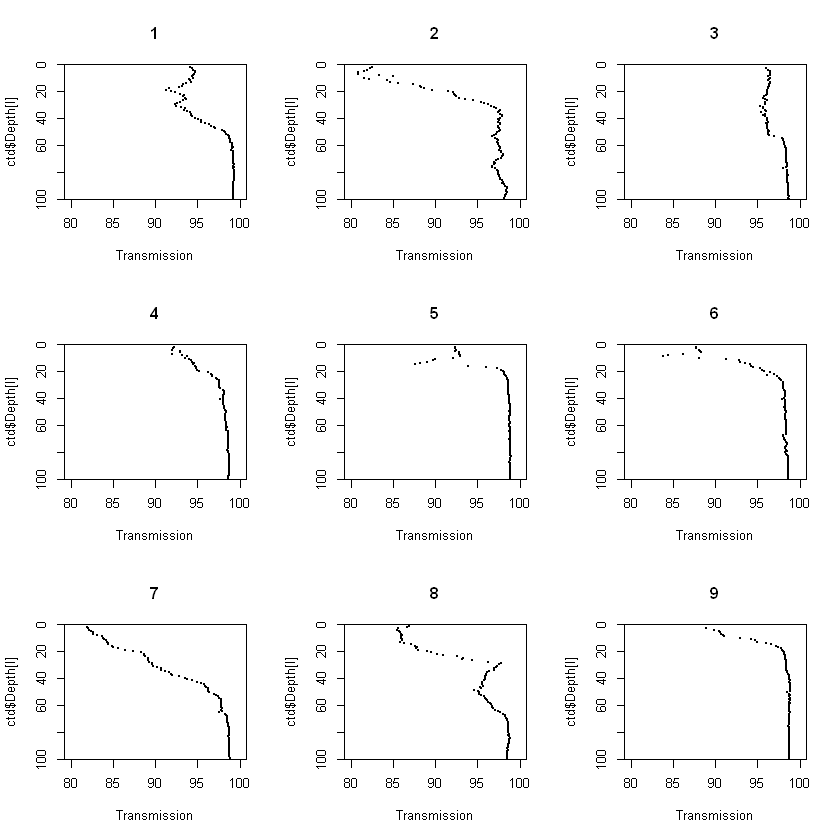

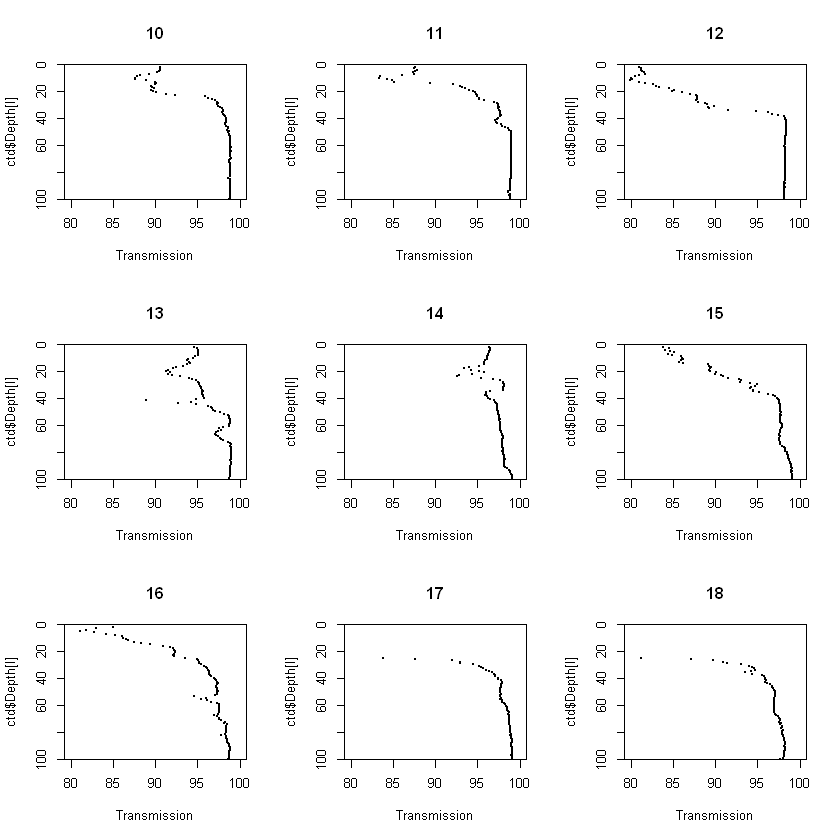

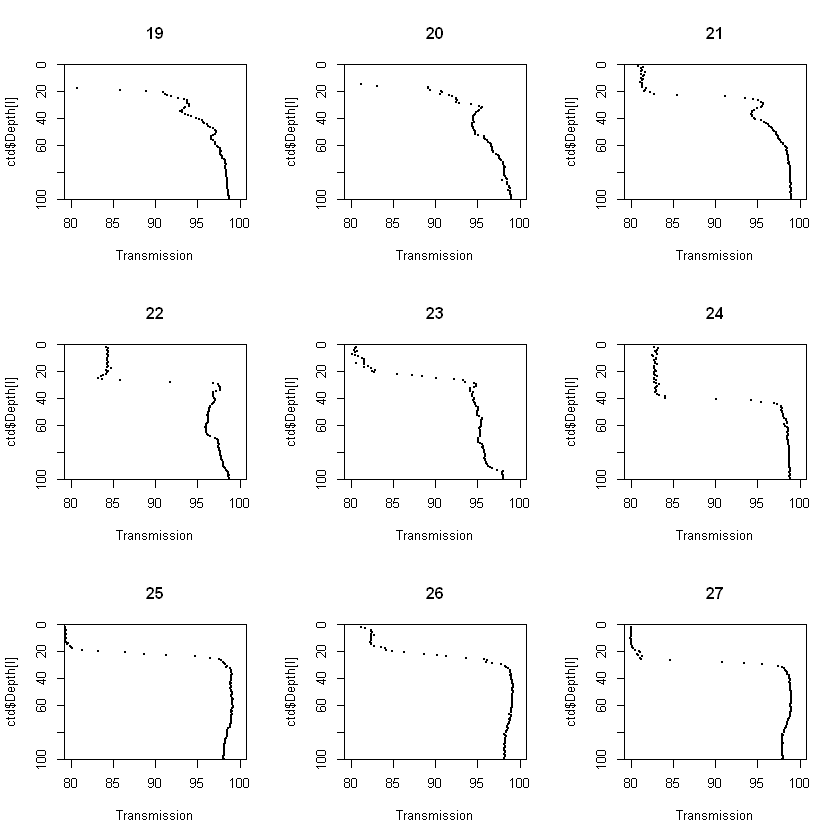

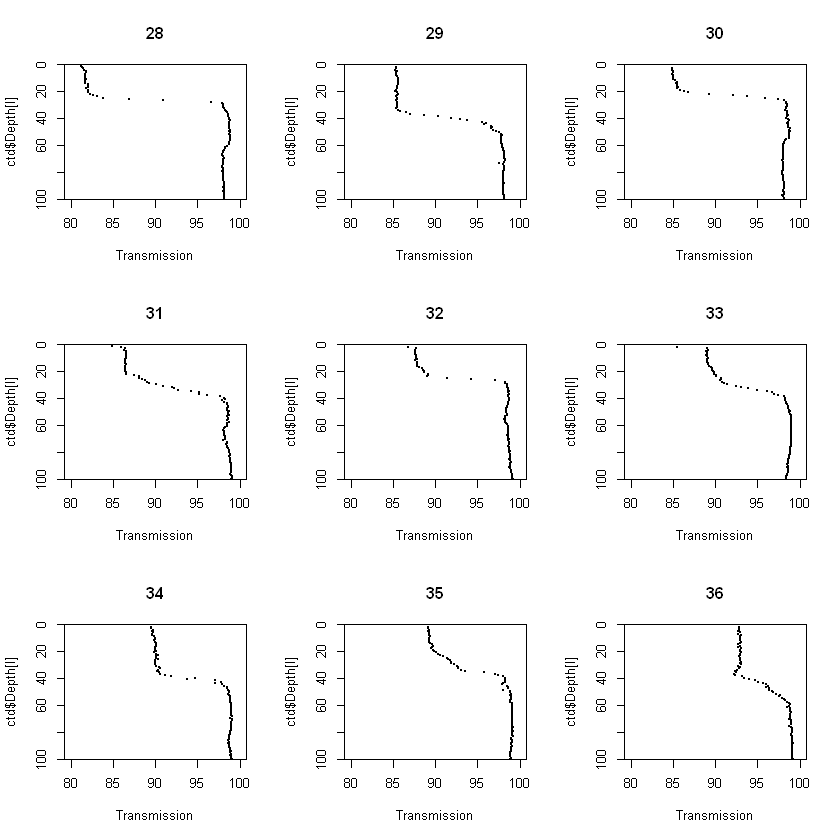

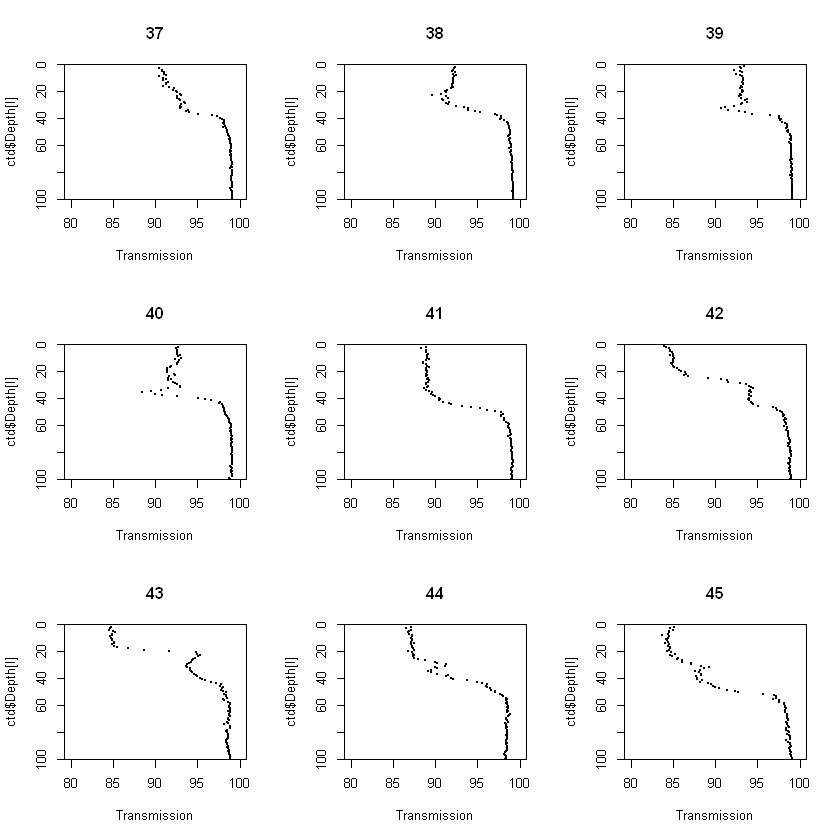

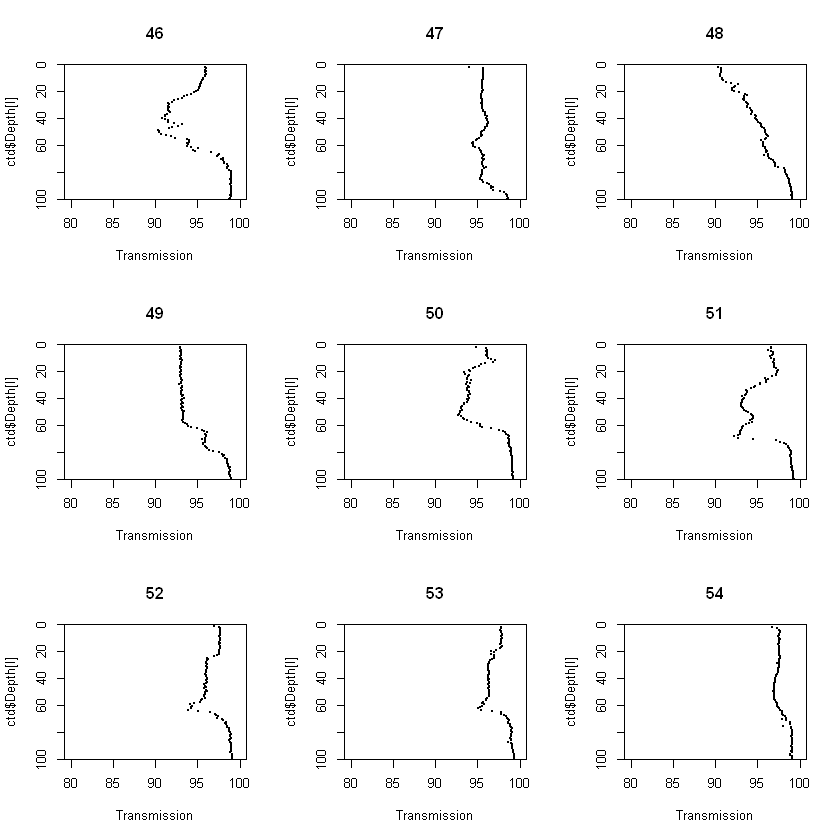

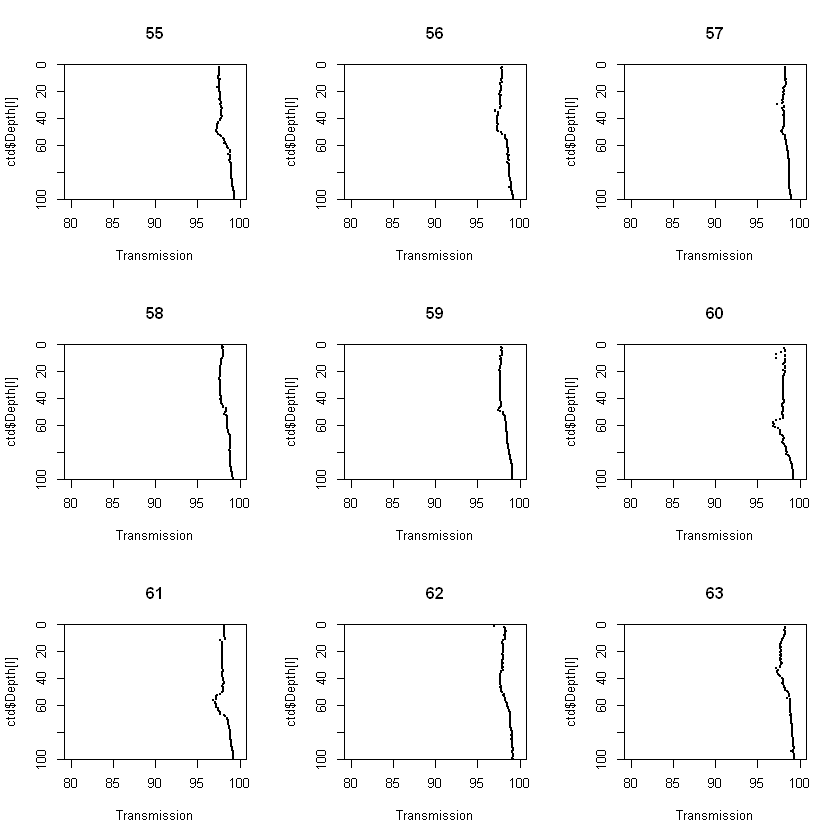

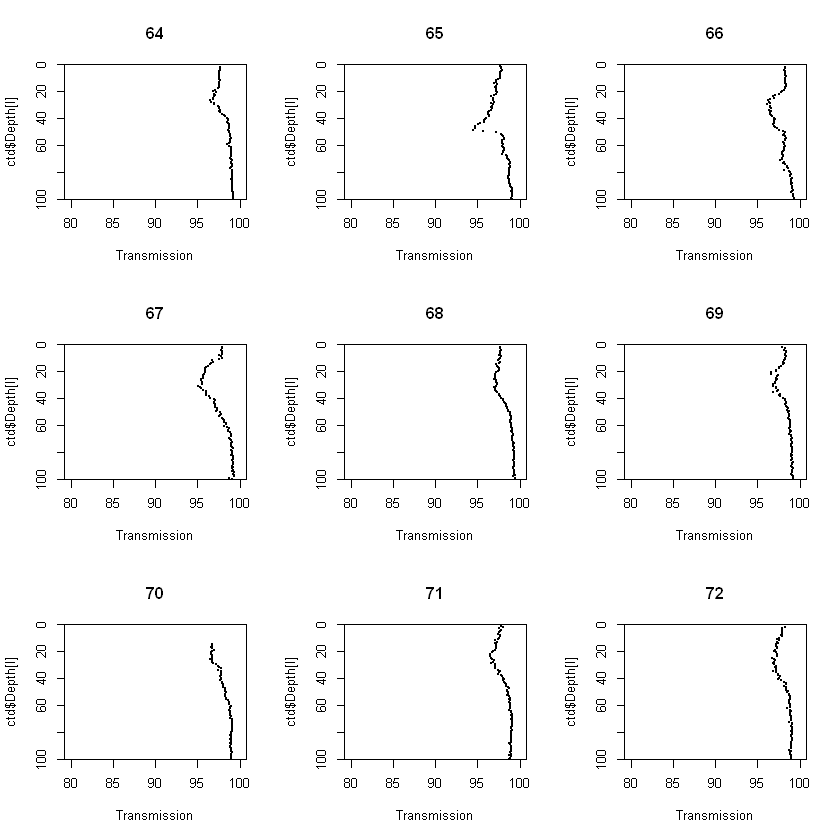

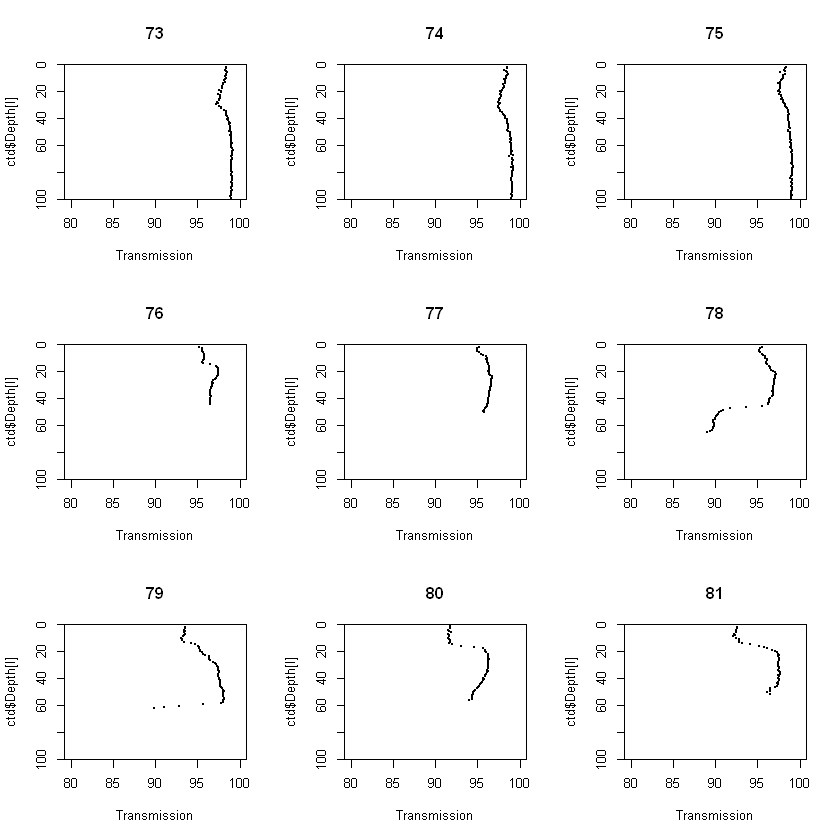

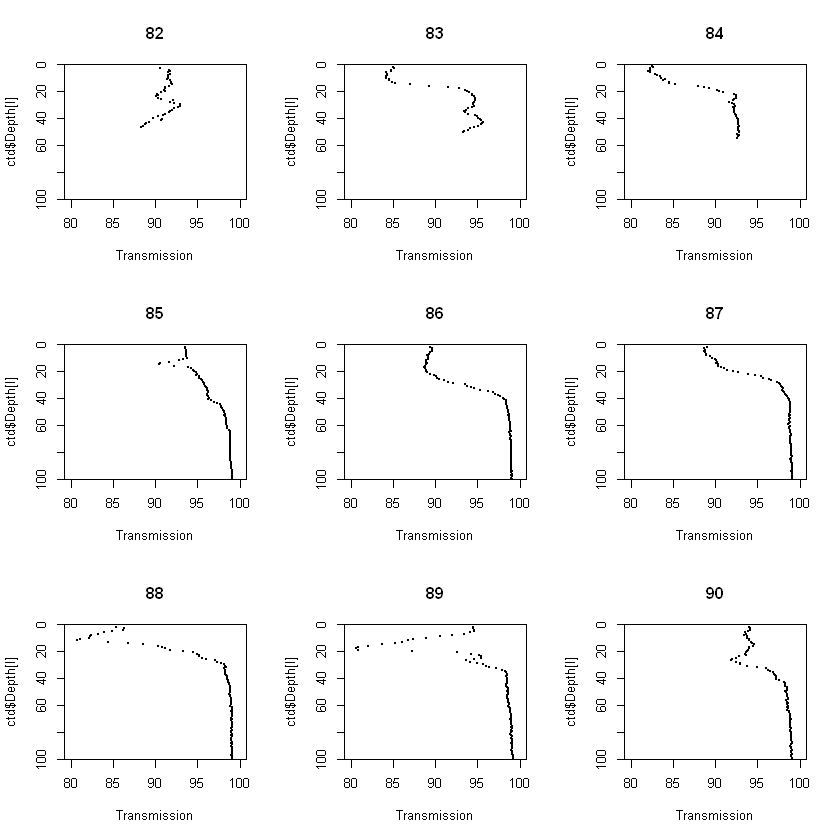

In [13]:
par(mfrow=c(3,3))
for (i in unique(ctd$Cast)) {
    l = which(ctd$Cast == i)
    plot(ctd$Trans[l], ctd$Depth[l], ylim=c(100,0), yaxs='i', xlab='Transmission', xlim=c(80,100), main=i, pch=16, cex=0.4)
}